# MSDS 498 Insurance Claims Model - GBM


In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=4cf9c170afadb89f8a3f9e2ac5aa67c4916de1c0d55c7fc0e95e85c9646ca52a
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import wandb
wandb.login(relogin = True)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
run = wandb.init()
datas = run.use_artifact('msds_498_claims_modeling/claims_modeling/sythetic_data:v5')
directory = datas.download(root = 'datasets')

wandb: Currently logged in as: danielpallotta2023 (msds_498_claims_modeling). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact sythetic_data:v5, 153.76MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:3.0


In [4]:
!pip install pyarrow
!pip install pandas
!pip install fastparquet
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyarrow
import fastparquet
from IPython.display import display

In [72]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pylab as plt

import pyarrow
import fastparquet
from IPython.display import display

## Step1: Read Training Data from CSV

Then the dataframe is split into train and test datasets using sklean's `train_test_split` function

In [73]:
targets = ['vehicle_claim_cnt_pd_0']
vars = ['vehicle_age', 'annual_mileage', 'vehicle_type', 'max_driver_age', 'min_driver_age',\
        'mean_driver_age', 'min_driver_tenure', 'youthful_driver_count', 'credit_score', 'garaging_location',\
        'household_tenure','multiline_houses', 'multiline_personal_article_policy', \
        'multiline_personal_liability_umbrella', 'multiline_rental', 'vehicle_count','vehicle_claim_time_since_all', \
        'driver_count','coverage_bi','coverage_coll','coverage_comp','coverage_ers','coverage_mpc','coverage_pd','coverage_ubi'
      ]

df_train = pd.read_parquet('./datasets/split=train')
df_test = pd.read_parquet('./datasets/split=test')
columns_to_keep = targets + vars
df_train = df_train[columns_to_keep]
df_test = df_test[columns_to_keep]
print(df_train.shape)
print(df_test.shape)

(220383, 26)
(63652, 26)


In [74]:
df_train = df_train.astype({
    'coverage_bi': int,
    'coverage_coll': int,
    'coverage_comp': int,
    'coverage_ers': int,
    'coverage_mpc': int,
    'coverage_pd': int,
    'coverage_ubi': int
})

df_test = df_test.astype({
    'coverage_bi': int,
    'coverage_coll': int,
    'coverage_comp': int,
    'coverage_ers': int,
    'coverage_mpc': int,
    'coverage_pd': int,
    'coverage_ubi': int
})

In [75]:
def find_nan_cols(df):
    null = df.isnull().sum()
    missing_df = pd.concat([null], axis=1, keys=['nancount'])

    return missing_df[(missing_df.nancount > 0)]

In [76]:
train_null = find_nan_cols(df_train)
test_null = find_nan_cols(df_test)
print('missing value in train_df -----------------------------')
print(train_null)
print('missing value in test_df ------------------------------')
print(test_null)

missing value in train_df -----------------------------
                              nancount
vehicle_claim_time_since_all    108701
missing value in test_df ------------------------------
                              nancount
vehicle_claim_time_since_all     31183


In [77]:
df_train = df_train.fillna(method='pad')
df_test = df_test.fillna(method='pad')
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

1
1


In [78]:
train_null = find_nan_cols(df_train)
test_null = find_nan_cols(df_test)
print('🚩 missing value in df_train -----------------------------')
print(train_null)
print('🚩 missing value in df_test ------------------------------')
print(test_null)

🚩 missing value in df_train -----------------------------
                              nancount
vehicle_claim_time_since_all         1
🚩 missing value in df_test ------------------------------
                              nancount
vehicle_claim_time_since_all         1


In [79]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [80]:
import statsmodels.api as sm

print('origint_df_train.shape()', df_train.shape)
df_train_ohe = pd.get_dummies(df_train)
print('df_train_ohe.shape()', df_train_ohe.shape)
df_train_ohe.head()

print('origint_df_test.shape()', df_test.shape)
df_test_ohe = pd.get_dummies(df_test)
print('df_test_ohe.shape()', df_test_ohe.shape)
df_test_ohe.head()

origint_df_train.shape() (220382, 26)
df_train_ohe.shape() (220382, 32)
origint_df_test.shape() (63651, 26)
df_test_ohe.shape() (63651, 32)


,vehicle_claim_cnt_pd_0,vehicle_age,annual_mileage,max_driver_age,min_driver_age,mean_driver_age,min_driver_tenure,youthful_driver_count,credit_score,household_tenure,...,coverage_pd,coverage_ubi,vehicle_type_pickup,vehicle_type_sedan,vehicle_type_sports car,vehicle_type_suv,vehicle_type_van,garaging_location_country,garaging_location_downtown,garaging_location_suburb
1,0,12,9000.0,44,40,42.000000,6,0,748,6,...,1,1,0,0,0,0,1,1,0,0
2,1,9,9000.0,66,62,64.000000,18,0,544,18,...,1,1,0,0,0,0,1,0,1,0
3,0,14,14000.0,49,47,48.000000,12,0,536,12,...,1,1,0,1,0,0,0,0,0,1
4,0,13,12000.0,55,17,41.333333,2,1,571,12,...,1,0,0,0,0,0,1,0,0,1
5,0,27,9000.0,40,36,38.000000,12,0,667,17,...,1,0,1,0,0,0,0,0,1,0


In [115]:
from sklearn.preprocessing import StandardScaler

# Identify the class with only one instance
single_class = df_train_ohe['vehicle_claim_cnt_pd_0'].value_counts().loc[lambda x: x == 1].index[0]

# Filter out the rows with the single class
df_train_filtered = df_train_ohe[df_train_ohe['vehicle_claim_cnt_pd_0'] != single_class]
df_test_filtered = df_test_ohe[df_test_ohe['vehicle_claim_cnt_pd_0'] != single_class]

# Separate the features and target again
X_train_filtered = df_train_filtered.drop('vehicle_claim_cnt_pd_0', axis=1)
y_train_filtered = df_train_filtered['vehicle_claim_cnt_pd_0']

X_test_filtered = df_test_filtered.drop('vehicle_claim_cnt_pd_0', axis=1)
y_test_filtered = df_test_filtered['vehicle_claim_cnt_pd_0']

# Check if any column has the same value for all rows
col_to_drop = []
for col in X_train_filtered.columns:
    if X_train_filtered[col].nunique() == 1:
        col_to_drop.append(col)

    # Remove the columns with the same value for all rows
if col_to_drop:
    X_train_filtered = X_train_filtered.drop(columns=col_to_drop)
    X_test_filtered = X_test_filtered.drop(columns=col_to_drop)

# Get column names
var_columns = X_train_filtered.columns.tolist()

# Scaling
standizer = StandardScaler()
X_train_filtered = standizer.fit_transform(X_train_filtered)
X_test_filtered = standizer.fit_transform(X_test_filtered)

In [82]:
model_gbm = GradientBoostingClassifier(n_estimators=5000,
                                       learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.5,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       max_features='log2',
                                       verbose=1)
model_gbm.fit(X_train_filtered, y_train_filtered)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.2882          -0.0018           86.90m
         2           0.2883           0.0008           74.37m
         3           0.2832           0.0018           68.54m
         4           0.2840           0.0003           63.49m
         5           0.3447          -0.0738           58.64m
         6           0.3095           0.0365           55.22m
         7           0.2997           0.0156           52.99m
         8           0.2984           0.0007           51.79m
         9           0.2965           0.0029           50.63m
        10           0.2935           0.0006           49.57m
        20 354376037360.3782 -355433432738.6561           44.42m
        30 261177268287082003913074249039872.0000           0.0001           46.04m
        40 156258122523.7241           0.0000           44.37m


GradientBoostingClassifier(learning_rate=0.05, max_features='log2',
                           n_estimators=5000, n_iter_no_change=20,
                           subsample=0.5, verbose=1)

In [102]:
y_train_pred = model_gbm.predict_proba(X_train_filtered)
y_test_pred = model_gbm.predict_proba(X_test_filtered)
print(y_train_pred.shape)
print(y_train_filtered.shape)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train_filtered, y_train_pred, multi_class='ovr'),
                                                    roc_auc_score(y_test_filtered, y_test_pred, multi_class='ovr')))

(220381, 4)
(220381,)
AUC Train: 0.7449
AUC Valid: 0.7108


## Step 2: Look at performance with respect to number of trees
`staged_predict_proba` function allows us to look at predictions at for different number of trees in the model

In [109]:
y_train_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_train_filtered)))
y_test_pred_trees = np.stack(list(model_gbm.staged_predict_proba(X_test_filtered)))

y_train_pred_trees.shape, y_test_pred_trees.shape

((107, 220381, 4), (107, 63651, 4))

In [111]:
auc_train_trees = [roc_auc_score(y_train_filtered, y_train_pred, multi_class='ovr') for y_train_pred in y_train_pred_trees]
auc_valid_trees = [roc_auc_score(y_test_filtered, y_test_pred, multi_class='ovr') for y_test_pred in y_test_pred_trees]

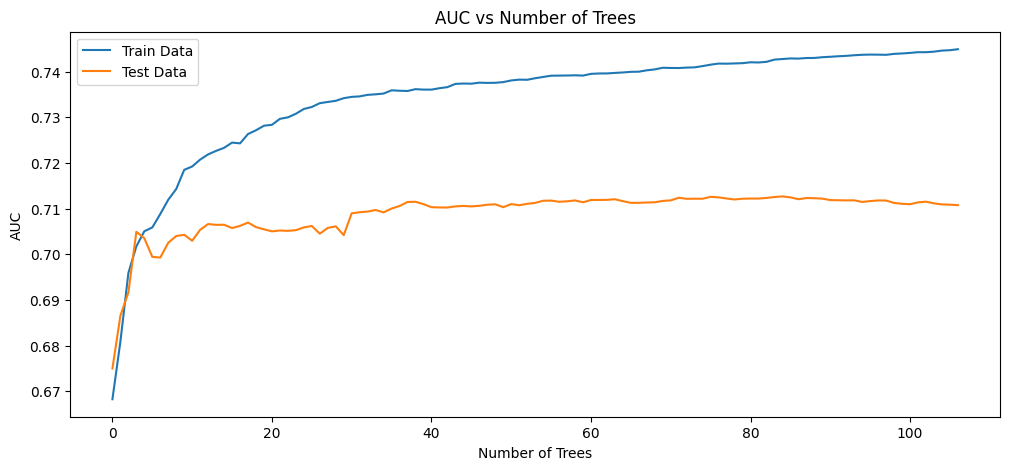

In [113]:
plt.figure(figsize=(12,5))

plt.plot(auc_train_trees, label='Train Data')
plt.plot(auc_valid_trees, label='Test Data')

plt.title('AUC vs Number of Trees')
plt.ylabel('AUC')
plt.xlabel('Number of Trees')
plt.legend()

plt.show()

## Step 3: Feature Importance
Low importance features can be removed from the model for simpler, faster and more stable model

In [116]:
pd.DataFrame({"Variable_Name":var_columns,
              "Importance":model_gbm.feature_importances_}) \
            .sort_values('Importance', ascending=False)

,Variable_Name,Importance
1,annual_mileage,0.382493
15,driver_count,0.101576
7,credit_score,0.100128
3,min_driver_age,0.077086
6,youthful_driver_count,0.074843
2,max_driver_age,0.046645
4,mean_driver_age,0.039451
13,vehicle_count,0.034009
0,vehicle_age,0.028706
5,min_driver_tenure,0.018799


### Step 4: Scoring for Test Data
First, read test.csv and sample_submissions.csv

In [ ]:
df_test = pd.read_csv('Source to Target Mapping - claims_data.csv')


df_test.shape

NameError: name 'pd' is not defined

In [ ]:
X_test = df_test.loc[:,var_columns]

df_sample_submission['target'] = model_gbm.predict_proba(X_test)[:,1]
df_sample_submission

NameError: name 'df_test' is not defined

Save the output as a csv